In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from qbraid import device_wrapper, job_wrapper, get_jobs
from qiskit import QuantumCircuit, transpile
from mitiq.zne.scaling import fold_gates_at_random
from mitiq.zne import inference

ModuleNotFoundError: No module named 'mitiq'

In [ ]:
@cirq.transformer
class SubstituteGate:
    """Transformer to substitute `source` gates with `target` in the input circuit."""

    def __init__(self, source, target):
        self._source = source
        self._target = target

    def __call__(self, circuit, *, context=None):
        batch_replace = []
        for i, op in circuit.findall_operations(lambda op: op.gate == self._source):
            batch_replace.append((i, op, self._target.on(*op.qubits)))
        transformed_circuit = circuit.unfreeze(copy=True)
        transformed_circuit.batch_replace(batch_replace)
        return transformed_circuit

substitute_h_inv = SubstituteGate(cirq.H**-1.0,cirq.H)
substitute_cnot_inv = SubstituteGate(cirq.CNOT**-1.0,cirq.CNOT)

In [ ]:
def prepare_correlated(env,n=2):
    # yield cirq.H(env[0])
    # yield cirq.H(env[0])
    yield cirq.H(env[1])
    yield cirq.CNOT(env[1],env[0])
    yield cirq.H(env[0])
    yield cirq.H(env[1])

def collide(env,sys,theta):
    yield cirq.CNOT(env,sys)
    yield cirq.rz(rads=2*theta).on(sys)
    yield cirq.CNOT(env,sys)

def collision_pattern_correlated(env,sys,n,theta):
    for i in range(n):
        yield from collide(env[1],sys,theta)

def meas_coherence(sys):
    yield cirq.H(sys)
    yield cirq.measure(sys, key = 'answer')

def collision_circuit(env,sys,n,theta):
    yield cirq.H(sys)
    yield from prepare_correlated(env,n)
    yield from collision_pattern_correlated(env,sys,n,theta)
    yield from meas_coherence(sys)

In [ ]:
n = 7
g = 1
tau = np.pi/6
t = np.array(list(range(1,n+1)))*tau
theta = g*tau

def corrfunc(time):
    return (np.cos(time)**2-np.sin(time)**2)/2

sys = cirq.LineQubit(0)
env = cirq.LineQubit.range(1,3)
repcnt = 1024

In [ ]:
device_id = "aws_oqc_lucy"
device = device_wrapper(device_id)
print(device.metadata())

In [123]:
ctest = cirq.Circuit(collision_circuit(env,sys,2,theta))
ctest_transpiled = device.transpile(ctest)
ctest_transpiled.probability(target=0)
print(ctest_transpiled)
print(device.verify_run(ctest_transpiled))

T  : |0|1|2|3|   4    |5|6|   7    |8|9|Result Types|
                                                     
q0 : -H-----X-Rz(1.05)-X-X-Rz(1.05)-X-H-Probability--
            |          | |          |                
q1 : -H-C---|----------|-|----------|----------------
        |   |          | |          |                
q2 : ---X-C-C----------C-|----------|----------------
          |              |          |                
q3 : -----X--------------C----------C----------------

T  : |0|1|2|3|   4    |5|6|   7    |8|9|Result Types|
None


/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/qbraid/providers/device.py:158: UserWarning: Device is currently offline. Depending on the provider queueing system, submitting this job may result in an exception or a long wait time.
  warnings.warn(


In [4]:
job_id_list = ['aws_oqc_lucy-contactmainakroy-qjob-cnyjtqb99ze6cgxh1i04', 'aws_oqc_lucy-contactmainakroy-qjob-bvpfi6ksfjmko64y9rw0', 'aws_oqc_lucy-contactmainakroy-qjob-4cpfspya341fgdoiav6k', 'aws_oqc_lucy-contactmainakroy-qjob-7zhr19e7vm5eatge6dmt', 'aws_oqc_lucy-contactmainakroy-qjob-wdjo3f0vhkf7tdt0htz9', 'aws_oqc_lucy-contactmainakroy-qjob-hv96m234ukwpss9q4bfg', 'aws_oqc_lucy-contactmainakroy-qjob-5l5s10jjy7ch2opkurec', 'aws_oqc_lucy-contactmainakroy-qjob-r7te174727p6d1xotllb', 'aws_oqc_lucy-contactmainakroy-qjob-4cl3d9vaqk0qec3lfw0m', 'aws_oqc_lucy-contactmainakroy-qjob-57vok0bs1g4cexy7lb48', 'aws_oqc_lucy-contactmainakroy-qjob-4zowawtr8wp7ggczvyh5', 'aws_oqc_lucy-contactmainakroy-qjob-st7tr5u2xinbzvmosf58', 'aws_oqc_lucy-contactmainakroy-qjob-j9gttk6t09hlp9326z4g', 'aws_oqc_lucy-contactmainakroy-qjob-brxzw2ntxtl05uycv2ie', 'aws_oqc_lucy-contactmainakroy-qjob-n59aejag3uk0x7h3mgwh', 'aws_oqc_lucy-contactmainakroy-qjob-3npskzsctou2aigjxzag', 'aws_oqc_lucy-contactmainakroy-qjob-ztkn91zmdc7zc204rdcw', 'aws_oqc_lucy-contactmainakroy-qjob-e92ewogyauvfjvim5lap', 'aws_oqc_lucy-contactmainakroy-qjob-vjyf4k07rvb82671lkk6', 'aws_oqc_lucy-contactmainakroy-qjob-1aoe47xhuk7ii2xmdeld']

In [11]:
for i in range(1,n+1):
    circuit = cirq.Circuit(collision_circuit(env,sys,i,theta))
    transpiled_circuit = device.transpile(circuit)
    job = device.run(transpiled_circuit,shots=repcnt)
    job_id_list.append(job.id)
    # result = simulator.run(circuit,repetitions=repcnt)
    # histogram = result.histogram(key = 'answer')
    # rho_12_corr.append((histogram[0]-histogram[1])/(2*repcnt))

<hr></hr>

In [16]:
print(job_id_list)

['aws_oqc_lucy-contactmainakroy-qjob-cnyjtqb99ze6cgxh1i04', 'aws_oqc_lucy-contactmainakroy-qjob-bvpfi6ksfjmko64y9rw0', 'aws_oqc_lucy-contactmainakroy-qjob-4cpfspya341fgdoiav6k', 'aws_oqc_lucy-contactmainakroy-qjob-7zhr19e7vm5eatge6dmt', 'aws_oqc_lucy-contactmainakroy-qjob-wdjo3f0vhkf7tdt0htz9', 'aws_oqc_lucy-contactmainakroy-qjob-hv96m234ukwpss9q4bfg', 'aws_oqc_lucy-contactmainakroy-qjob-5l5s10jjy7ch2opkurec', 'aws_oqc_lucy-contactmainakroy-qjob-r7te174727p6d1xotllb', 'aws_oqc_lucy-contactmainakroy-qjob-4cl3d9vaqk0qec3lfw0m', 'aws_oqc_lucy-contactmainakroy-qjob-57vok0bs1g4cexy7lb48', 'aws_oqc_lucy-contactmainakroy-qjob-4zowawtr8wp7ggczvyh5', 'aws_oqc_lucy-contactmainakroy-qjob-st7tr5u2xinbzvmosf58', 'aws_oqc_lucy-contactmainakroy-qjob-j9gttk6t09hlp9326z4g', 'aws_oqc_lucy-contactmainakroy-qjob-brxzw2ntxtl05uycv2ie', 'aws_oqc_lucy-contactmainakroy-qjob-n59aejag3uk0x7h3mgwh', 'aws_oqc_lucy-contactmainakroy-qjob-3npskzsctou2aigjxzag', 'aws_oqc_lucy-contactmainakroy-qjob-ztkn91zmdc7zc204rdc

The below cell takes like...5 minutes to run

In [5]:
results = [job_wrapper(job_id).result() for job_id in job_id_list]

In [16]:
rho_12_corr = []

for result in results:
    probs = result._result.measurement_probabilities
    prob1 = 0.0
    prob0 = 0.0
    for key,val in probs.items():
        # print(key[0])
        if key[0]=='0':
            prob0 += val
        else:
            prob1 += val
    # print(prob0+prob1)
    rho_12_corr.append((prob0-prob1)/2)

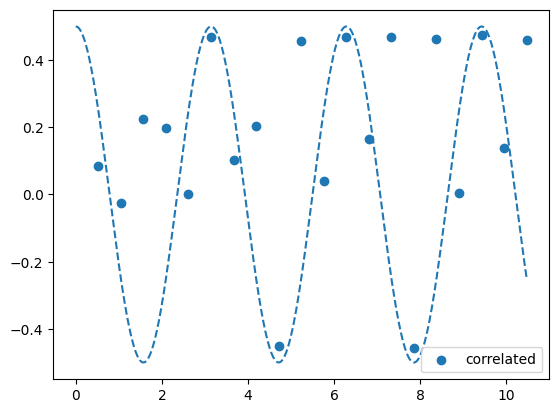

In [17]:
def corrfunc(time):
    return (np.cos(time)**2-np.sin(time)**2)/2

x_ax = np.linspace(0,t[-1],num=1000)

plt.scatter(t,rho_12_corr,label='correlated')
plt.plot(x_ax,corrfunc(x_ax),linestyle='--')
plt.legend()
plt.show()